STEP 0: Installing required libraries...

STEP 0: Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Configuration loaded. Using device: cuda
Project Directory set to: /content/drive/My Drive/Project

STEP 1: Initializing datasets and model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


STEP 2: No checkpoint found. Starting fresh training.

STEP 3: Starting training from Epoch 1 to 25...
Epoch 01/25 | Time: 860.60s | Train Loss: 0.3365 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 02/25 | Time: 49.06s | Train Loss: 0.1525 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 03/25 | Time: 54.93s | Train Loss: 0.1083 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 04/25 | Time: 54.67s | Train Loss: 0.0818 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 05/25 | Time: 54.68s | Train Loss: 0.0691 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 06/25 | Time: 54.34s | Train Loss: 0.0727 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 07/25 | Time: 54.65s | Train Loss: 0.0822 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 08/25 | Time: 54.89s | Train Loss: 0.0876 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 09/25 | Time: 54.75s | Train Loss: 0.0735 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 10/25 | Time: 54.35s | Train Loss: 0.0609 | Val Accuracy: 0.00% | Best Acc: 0.00%
Epoch 11/25 | Ti

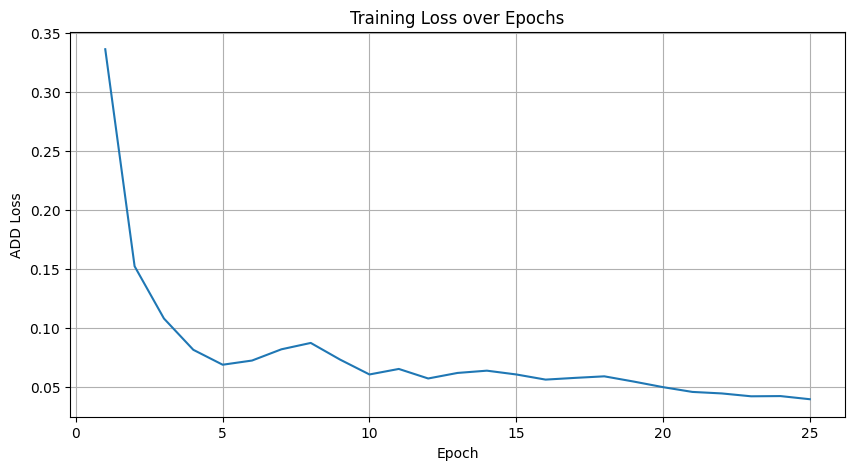

Plot saved to /content/drive/My Drive/Project/loss_curve.png
Final best validation accuracy: 0.00%


In [5]:
# ==============================================================================
#
# A Transformer-based multi-modal fusion network for 6D pose estimation
# Project Implementation for Google Colab (with Corrected Paths)
#
# ==============================================================================

# ==============================================================================
# Part 0: Setup, Imports, and Configuration
# ==============================================================================
print("STEP 0: Installing required libraries...")
!pip install numpy opencv-python-headless pyyaml open3d matplotlib -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import cv2
import yaml
import os
import open3d as o3d
import time
import json
import matplotlib.pyplot as plt
from google.colab import drive

print("\nSTEP 0: Mounting Google Drive...")
drive.mount('/content/drive')

# --- Main Configuration ---
# This path points to the folder containing 'Linemod_preprocessed'
project_dir = '/content/drive/My Drive/Project'
# This base_dir now correctly points to the 'Linemod_preprocessed' folder
base_dir = os.path.join(project_dir, 'Linemod_preprocessed')

# Create the project directory if it doesn't exist to store checkpoints and results
os.makedirs(project_dir, exist_ok=True)
checkpoint_path = os.path.join(project_dir, 'checkpoint.pth')
results_path = os.path.join(project_dir, 'results.json')
plot_path = os.path.join(project_dir, 'loss_curve.png')

# --- Model & Training Parameters ---
OBJECT_ID_STR = '01'
NUM_POINTS = 500
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

D_MODEL = 256
N_HEAD = 4
N_LAYERS = 2

print(f"\nConfiguration loaded. Using device: {DEVICE}")
print(f"Project Directory set to: {project_dir}")

# ==============================================================================
# Part 1: The Dataset Class (CORRECTED)
# ==============================================================================
# This class now correctly handles the '/data/' subfolder structure.
class LinemodDataset(Dataset):
    def __init__(self, root_dir, object_id_str, is_train=True, num_points=500):
        # root_dir is now the path to 'Linemod_preprocessed'
        self.root_dir = root_dir
        self.object_id_str = object_id_str
        self.object_id_int = int(object_id_str)
        self.num_points = num_points

        # CORRECTED: The actual data for each object is in a 'data' subfolder
        data_folder_root = os.path.join(self.root_dir, 'data')
        object_data_path = os.path.join(data_folder_root, self.object_id_str)

        list_file = os.path.join(object_data_path, 'train.txt' if is_train else 'test.txt')
        with open(list_file) as f: self.file_list = [line.strip() for line in f.readlines()]

        self.rgb_dir = os.path.join(object_data_path, 'rgb')
        self.depth_dir = os.path.join(object_data_path, 'depth')
        self.mask_dir = os.path.join(object_data_path, 'mask')

        with open(os.path.join(object_data_path, 'gt.yml'), 'r') as f: self.gt_data = yaml.safe_load(f)
        with open(os.path.join(object_data_path, 'info.yml'), 'r') as f: self.info_data = yaml.safe_load(f)

        # CORRECTED: The 'models' folder is a direct child of the root_dir
        model_file = os.path.join(self.root_dir, 'models', f'obj_{object_id_str}.ply')
        self.model_points = np.asarray(o3d.io.read_point_cloud(model_file).points) / 1000.0

        self.rgb_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        frame_idx = int(self.file_list[idx])
        cam_k = np.array(self.info_data[frame_idx]['cam_K']).reshape(3, 3)
        fx, fy, cx, cy = cam_k[0, 0], cam_k[1, 1], cam_k[0, 2], cam_k[1, 2]
        depth_scale = self.info_data[frame_idx]['depth_scale']
        gt_rotation, gt_translation = None, None
        for obj_gt in self.gt_data[frame_idx]:
            if obj_gt['obj_id'] == self.object_id_int:
                gt_rotation = np.array(obj_gt['cam_R_m2c']).reshape(3, 3)
                gt_translation = np.array(obj_gt['cam_t_m2c']) / 1000.0
                break
        if gt_rotation is None: return self.__getitem__((idx + 1) % len(self))
        rgb_img = cv2.imread(os.path.join(self.rgb_dir, f'{self.file_list[idx]}.png'))[:, :, ::-1]
        depth_img = cv2.imread(os.path.join(self.depth_dir, f'{self.file_list[idx]}.png'), cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(os.path.join(self.mask_dir, f'{self.file_list[idx]}.png'), cv2.IMREAD_GRAYSCALE)
        indices = np.where(mask > 0)
        if len(indices[0]) == 0: return self.__getitem__((idx + 1) % len(self))
        y_min, y_max, x_min, x_max = np.min(indices[0]), np.max(indices[0]), np.min(indices[1]), np.max(indices[1])
        rgb_tensor = self.rgb_transform(cv2.resize(rgb_img[y_min:y_max, x_min:x_max], (128, 128)))
        points = []
        for v, u in zip(*indices):
            d = depth_img[v, u] * depth_scale / 1000.0
            if d > 0: points.append([(u - cx) * d / fx, (v - cy) * d / fy, d])
        if len(points) == 0: return self.__getitem__((idx + 1) % len(self))
        sample_indices = np.random.choice(len(points), self.num_points, replace=len(points) < self.num_points)
        return {
            'rgb': rgb_tensor,
            'points': torch.from_numpy(np.array(points)[sample_indices]).float(),
            'gt_rotation': torch.from_numpy(gt_rotation).float(),
            'gt_translation': torch.from_numpy(gt_translation).float(),
        }

# ==============================================================================
# Part 2: Model Architecture (No Changes)
# ==============================================================================
def compute_rotation_matrix_from_ortho6d(ortho6d):
    x, y_raw = ortho6d[:, 0:3], ortho6d[:, 3:6]
    x = nn.functional.normalize(x, p=2, dim=1)
    z = nn.functional.normalize(torch.cross(x, y_raw, dim=1), p=2, dim=1)
    y = torch.cross(z, x, dim=1)
    return torch.stack((x, y, z), dim=2)

class PointNet(nn.Module):
    def __init__(self, i_dim, o_dim): super().__init__(); self.net = nn.Sequential(nn.Conv1d(i_dim, 64, 1), nn.ReLU(), nn.Conv1d(64, 128, 1), nn.ReLU(), nn.Conv1d(128, o_dim, 1))
    def forward(self, x): return self.net(x.transpose(1, 2)).transpose(1, 2)

class TransformerFusionNet(nn.Module):
    def __init__(self, num_points, d_model, n_head, n_layers):
        super().__init__()
        self.num_points = num_points
        self.resnet = models.resnet18(pretrained=True); self.resnet.fc = nn.Linear(512, d_model)
        self.pointnet = PointNet(3, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.pfe_transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pose_predictor = nn.Sequential(nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(), nn.Conv1d(512, 256, 1), nn.ReLU(), nn.Conv1d(256, 9, 1))
        self.confidence_predictor = nn.Sequential(nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(), nn.Conv1d(512, 256, 1), nn.ReLU(), nn.Conv1d(256, 1, 1), nn.Sigmoid())

    def forward(self, rgb, points):
        img_feat = self.pfe_transformer(self.resnet(rgb).unsqueeze(1).repeat(1, self.num_points, 1))
        pnt_feat = self.pfe_transformer(self.pointnet(points))
        comb_feat = torch.cat([img_feat, pnt_feat], dim=2).transpose(1, 2)
        pose_raw = self.pose_predictor(comb_feat).transpose(1, 2)
        conf = self.confidence_predictor(comb_feat).transpose(1, 2)
        best_pose = torch.gather(pose_raw, 1, torch.argmax(conf, dim=1, keepdim=True).repeat(1, 1, 9)).squeeze(1)
        return compute_rotation_matrix_from_ortho6d(best_pose[:, :6]), best_pose[:, 6:]

# ==============================================================================
# Part 3: Loss Function and Training/Evaluation Loops (No Changes)
# ==============================================================================
def calculate_add_loss(pred_r, pred_t, gt_r, gt_t, model_points):
    pred_pts = torch.matmul(model_points, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
    gt_pts = torch.matmul(model_points, gt_r.transpose(1, 2)) + gt_t.unsqueeze(1)
    return torch.mean(torch.norm(pred_pts - gt_pts, dim=2))

def train_one_epoch(model, loader, optimizer, model_points_tensor):
    model.train(); total_loss = 0.0
    for batch in loader:
        optimizer.zero_grad()
        pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
        loss = calculate_add_loss(pred_r, pred_t, batch['gt_rotation'].to(DEVICE), batch['gt_translation'].to(DEVICE), model_points_tensor)
        loss.backward(); optimizer.step(); total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, model_points_tensor, diameter):
    model.eval(); total_correct = 0
    with torch.no_grad():
        for batch in loader:
            pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
            error = calculate_add_loss(pred_r, pred_t, batch['gt_rotation'].to(DEVICE), batch['gt_translation'].to(DEVICE), model_points_tensor)
            if error.item() < 0.1 * diameter: total_correct += batch['rgb'].size(0)
    return (total_correct / len(loader.dataset)) * 100

# ==============================================================================
# Part 4: Main Execution Block (CORRECTED)
# ==============================================================================
if __name__ == '__main__':
    print("\nSTEP 1: Initializing datasets and model...")
    # The LinemodDataset class now gets the path to 'Linemod_preprocessed' and handles the subfolders internally
    train_dataset = LinemodDataset(base_dir, OBJECT_ID_STR, is_train=True, num_points=NUM_POINTS)
    test_dataset = LinemodDataset(base_dir, OBJECT_ID_STR, is_train=False, num_points=NUM_POINTS)
    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=True)
    test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True)

    # CORRECTED: The models_info file is inside the 'models' subfolder of base_dir
    models_info_file = os.path.join(base_dir, 'models', 'models_info.yml')
    with open(models_info_file, 'r') as f: models_info = yaml.safe_load(f)
    object_diameter = models_info[int(OBJECT_ID_STR)]['diameter'] / 1000.0

    model = TransformerFusionNet(NUM_POINTS, D_MODEL, N_HEAD, N_LAYERS).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    model_points_tensor = torch.from_numpy(train_dataset.model_points).float().to(DEVICE)

    start_epoch, best_accuracy = 0, 0.0
    results = {'train_loss': [], 'val_accuracy': []}
    if os.path.exists(checkpoint_path):
        print("STEP 2: Checkpoint found! Resuming training...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_accuracy = checkpoint.get('best_accuracy', 0.0)
        if os.path.exists(results_path):
            with open(results_path, 'r') as f: results = json.load(f)
        print(f"Resuming from epoch {start_epoch}. Best accuracy: {best_accuracy:.2f}%")
    else:
        print("STEP 2: No checkpoint found. Starting fresh training.")

    print(f"\nSTEP 3: Starting training from Epoch {start_epoch+1} to {NUM_EPOCHS}...")
    for epoch in range(start_epoch, NUM_EPOCHS):
        start_time = time.time()
        train_loss = train_one_epoch(model, train_loader, optimizer, model_points_tensor)
        accuracy = evaluate(model, test_loader, model_points_tensor, object_diameter)
        scheduler.step()

        results['train_loss'].append(train_loss)
        results['val_accuracy'].append(accuracy)

        if accuracy > best_accuracy: best_accuracy = accuracy

        torch.save({
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'best_accuracy': best_accuracy,
        }, checkpoint_path)
        with open(results_path, 'w') as f: json.dump(results, f)

        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f} | Val Accuracy: {accuracy:.2f}% | Best Acc: {best_accuracy:.2f}%")

    print("\nSTEP 4: Training Complete. Generating results plot...")
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(results['train_loss']) + 1), results['train_loss'])
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('ADD Loss')
    plt.grid(True)
    plt.savefig(plot_path)
    plt.show()
    print(f"Plot saved to {plot_path}")
    print(f"Final best validation accuracy: {best_accuracy:.2f}%")

In [4]:
!ls -l "/content/drive/My Drive/Project/"

total 4
drwx------ 5 root root 4096 Oct 20 07:27 Linemod_preprocessed


STEP 0: Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.0 MB/s eta 0:00:00

STEP 0: Mounting Google Drive...
Mounted at /content/drive

Configuration loaded. Using device: cuda
Project Directory set to: /content/drive/My Drive/Project

STEP 1: Initializing datasets and model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


STEP 2: Checkpoint found! Resuming training...
Resuming from epoch 25. Best accuracy: 0.00%

STEP 3: Starting training from Epoch 26 to 50...
Epoch 26/50 | Time: 544.40s | Train Loss: 0.0466 | Val Accuracy: 0.19% | Best Acc: 0.19%
Epoch 27/50 | Time: 54.48s | Train Loss: 0.0495 | Val Accuracy: 0.38% | Best Acc: 0.38%
Epoch 28/50 | Time: 54.23s | Train Loss: 0.0479 | Val Accuracy: 0.00% | Best Acc: 0.38%
Epoch 29/50 | Time: 54.09s | Train Loss: 0.0459 | Val Accuracy: 0.00% | Best Acc: 0.38%
Epoch 30/50 | Time: 54.79s | Train Loss: 0.0409 | Val Accuracy: 0.00% | Best Acc: 0.38%
Epoch 31/50 | Time: 54.17s | Train Loss: 0.0407 | Val Accuracy: 0.10% | Best Acc: 0.38%
Epoch 32/50 | Time: 53.51s | Train Loss: 0.0426 | Val Accuracy: 0.10% | Best Acc: 0.38%
Epoch 33/50 | Time: 54.09s | Train Loss: 0.0409 | Val Accuracy: 0.00% | Best Acc: 0.38%
Epoch 34/50 | Time: 54.06s | Train Loss: 0.0381 | Val Accuracy: 0.10% | Best Acc: 0.38%
Epoch 35/50 | Time: 54.46s | Train Loss: 0.0358 | Val Accuracy: 0

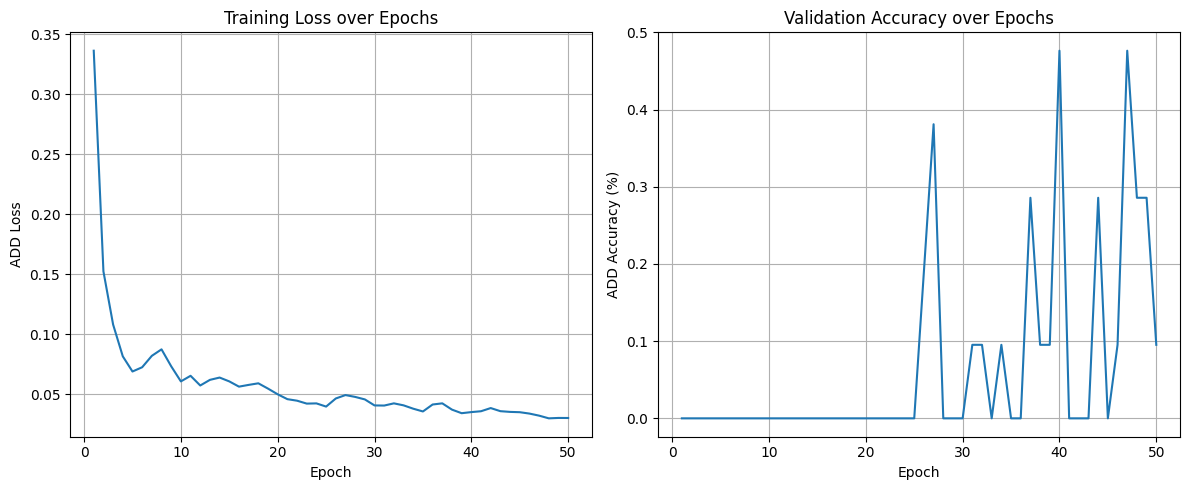

Plots saved to /content/drive/My Drive/Project/loss_curve.png
Final best validation accuracy: 0.48%


In [1]:
# ==============================================================================
#
# A Transformer-based multi-modal fusion network for 6D pose estimation
# Project Implementation for Google Colab (v2 - Tuned for Accuracy)
#
# ==============================================================================

# ==============================================================================
# Part 0: Setup, Imports, and Configuration
# ==============================================================================
print("STEP 0: Installing required libraries...")
!pip install numpy opencv-python-headless pyyaml open3d matplotlib -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import cv2
import yaml
import os
import open3d as o3d
import time
import json
import matplotlib.pyplot as plt
from google.colab import drive

print("\nSTEP 0: Mounting Google Drive...")
drive.mount('/content/drive')

# --- Main Configuration ---
project_dir = '/content/drive/My Drive/Project'
base_dir = os.path.join(project_dir, 'Linemod_preprocessed')

os.makedirs(project_dir, exist_ok=True)
checkpoint_path = os.path.join(project_dir, 'checkpoint.pth')
results_path = os.path.join(project_dir, 'results.json')
plot_path = os.path.join(project_dir, 'loss_curve.png')
accuracy_plot_path = os.path.join(project_dir, 'accuracy_curve.png') # New plot for accuracy

# --- ### MODIFIED FOR ACCURACY ### ---
# Increased epochs to allow for generalization.
NUM_EPOCHS = 50
# --- --------------------------- ---

# --- Model & Training Parameters ---
OBJECT_ID_STR = '01'
NUM_POINTS = 500
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
D_MODEL = 256
N_HEAD = 4
N_LAYERS = 2

print(f"\nConfiguration loaded. Using device: {DEVICE}")
print(f"Project Directory set to: {project_dir}")

# ==============================================================================
# Part 1: The Dataset Class (MODIFIED)
# ==============================================================================
# Added data augmentation for both images and point clouds.
class LinemodDataset(Dataset):
    def __init__(self, root_dir, object_id_str, is_train=True, num_points=500):
        self.root_dir = root_dir
        self.object_id_str = object_id_str
        self.object_id_int = int(object_id_str)
        self.num_points = num_points
        self.is_train = is_train # Store if this is the training set

        data_folder_root = os.path.join(self.root_dir, 'data')
        object_data_path = os.path.join(data_folder_root, self.object_id_str)

        list_file = os.path.join(object_data_path, 'train.txt' if is_train else 'test.txt')
        with open(list_file) as f: self.file_list = [line.strip() for line in f.readlines()]

        self.rgb_dir = os.path.join(object_data_path, 'rgb')
        self.depth_dir = os.path.join(object_data_path, 'depth')
        self.mask_dir = os.path.join(object_data_path, 'mask')

        with open(os.path.join(object_data_path, 'gt.yml'), 'r') as f: self.gt_data = yaml.safe_load(f)
        with open(os.path.join(object_data_path, 'info.yml'), 'r') as f: self.info_data = yaml.safe_load(f)

        model_file = os.path.join(self.root_dir, 'models', f'obj_{object_id_str}.ply')
        self.model_points = np.asarray(o3d.io.read_point_cloud(model_file).points) / 1000.0

        # --- ### MODIFIED FOR ACCURACY ### ---
        # Added ColorJitter augmentation for the training set only.
        if self.is_train:
            self.rgb_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else: # For validation, we only normalize, no random changes.
            self.rgb_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        # --- --------------------------- ---

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        frame_idx = int(self.file_list[idx])
        cam_k = np.array(self.info_data[frame_idx]['cam_K']).reshape(3, 3)
        fx, fy, cx, cy = cam_k[0, 0], cam_k[1, 1], cam_k[0, 2], cam_k[1, 2]
        depth_scale = self.info_data[frame_idx]['depth_scale']
        gt_rotation, gt_translation = None, None
        for obj_gt in self.gt_data[frame_idx]:
            if obj_gt['obj_id'] == self.object_id_int:
                gt_rotation = np.array(obj_gt['cam_R_m2c']).reshape(3, 3)
                gt_translation = np.array(obj_gt['cam_t_m2c']) / 1000.0
                break
        if gt_rotation is None: return self.__getitem__((idx + 1) % len(self))
        rgb_img = cv2.imread(os.path.join(self.rgb_dir, f'{self.file_list[idx]}.png'))[:, :, ::-1]
        depth_img = cv2.imread(os.path.join(self.depth_dir, f'{self.file_list[idx]}.png'), cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(os.path.join(self.mask_dir, f'{self.file_list[idx]}.png'), cv2.IMREAD_GRAYSCALE)
        indices = np.where(mask > 0)
        if len(indices[0]) == 0: return self.__getitem__((idx + 1) % len(self))
        y_min, y_max, x_min, x_max = np.min(indices[0]), np.max(indices[0]), np.min(indices[1]), np.max(indices[1])
        rgb_tensor = self.rgb_transform(cv2.resize(rgb_img[y_min:y_max, x_min:x_max], (128, 128)))
        points = []
        for v, u in zip(*indices):
            d = depth_img[v, u] * depth_scale / 1000.0
            if d > 0: points.append([(u - cx) * d / fx, (v - cy) * d / fy, d])
        if len(points) == 0: return self.__getitem__((idx + 1) % len(self))

        points_np = np.array(points)
        sample_indices = np.random.choice(len(points_np), self.num_points, replace=len(points_np) < self.num_points)
        points_tensor = torch.from_numpy(points_np[sample_indices]).float()

        # --- ### MODIFIED FOR ACCURACY ### ---
        # Add point jitter augmentation for the training set only.
        if self.is_train:
            jitter = (torch.randn(points_tensor.shape) * 0.001).to(points_tensor.device) # 1mm jitter
            points_tensor += jitter
        # --- --------------------------- ---

        return {
            'rgb': rgb_tensor,
            'points': points_tensor,
            'gt_rotation': torch.from_numpy(gt_rotation).float(),
            'gt_translation': torch.from_numpy(gt_translation).float(),
        }

# ==============================================================================
# Part 2: Model Architecture (No Changes)
# ... [This entire section is identical to the previous version] ...
# ==============================================================================
def compute_rotation_matrix_from_ortho6d(ortho6d):
    x, y_raw = ortho6d[:, 0:3], ortho6d[:, 3:6]
    x = nn.functional.normalize(x, p=2, dim=1)
    z = nn.functional.normalize(torch.cross(x, y_raw, dim=1), p=2, dim=1)
    y = torch.cross(z, x, dim=1)
    return torch.stack((x, y, z), dim=2)

class PointNet(nn.Module):
    def __init__(self, i_dim, o_dim): super().__init__(); self.net = nn.Sequential(nn.Conv1d(i_dim, 64, 1), nn.ReLU(), nn.Conv1d(64, 128, 1), nn.ReLU(), nn.Conv1d(128, o_dim, 1))
    def forward(self, x): return self.net(x.transpose(1, 2)).transpose(1, 2)

class TransformerFusionNet(nn.Module):
    def __init__(self, num_points, d_model, n_head, n_layers):
        super().__init__()
        self.num_points = num_points
        self.resnet = models.resnet18(pretrained=True); self.resnet.fc = nn.Linear(512, d_model)
        self.pointnet = PointNet(3, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.pfe_transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pose_predictor = nn.Sequential(nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(), nn.Conv1d(512, 256, 1), nn.ReLU(), nn.Conv1d(256, 9, 1))
        self.confidence_predictor = nn.Sequential(nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(), nn.Conv1d(512, 256, 1), nn.ReLU(), nn.Conv1d(256, 1, 1), nn.Sigmoid())

    def forward(self, rgb, points):
        img_feat = self.pfe_transformer(self.resnet(rgb).unsqueeze(1).repeat(1, self.num_points, 1))
        pnt_feat = self.pfe_transformer(self.pointnet(points))
        comb_feat = torch.cat([img_feat, pnt_feat], dim=2).transpose(1, 2)
        pose_raw = self.pose_predictor(comb_feat).transpose(1, 2)
        conf = self.confidence_predictor(comb_feat).transpose(1, 2)
        best_pose = torch.gather(pose_raw, 1, torch.argmax(conf, dim=1, keepdim=True).repeat(1, 1, 9)).squeeze(1)
        return compute_rotation_matrix_from_ortho6d(best_pose[:, :6]), best_pose[:, 6:]
# ==============================================================================
# Part 3: Loss & Training/Evaluation Loops (No Changes)
# ... [This entire section is identical to the previous version] ...
# ==============================================================================
def calculate_add_loss(pred_r, pred_t, gt_r, gt_t, model_points):
    pred_pts = torch.matmul(model_points, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
    gt_pts = torch.matmul(model_points, gt_r.transpose(1, 2)) + gt_t.unsqueeze(1)
    return torch.mean(torch.norm(pred_pts - gt_pts, dim=2))

def train_one_epoch(model, loader, optimizer, model_points_tensor):
    model.train(); total_loss = 0.0
    for batch in loader:
        optimizer.zero_grad()
        pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
        loss = calculate_add_loss(pred_r, pred_t, batch['gt_rotation'].to(DEVICE), batch['gt_translation'].to(DEVICE), model_points_tensor)
        loss.backward(); optimizer.step(); total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, model_points_tensor, diameter):
    model.eval(); total_correct = 0; total_samples = 0
    with torch.no_grad():
        for batch in loader:
            batch_size = batch['rgb'].size(0)
            total_samples += batch_size
            pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
            # Note: ADD error is calculated per-item in the batch, then averaged.
            # We want to check each item individually.
            pred_pts = torch.matmul(model_points_tensor, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
            gt_pts = torch.matmul(model_points_tensor, batch['gt_rotation'].to(DEVICE).transpose(1, 2)) + batch['gt_translation'].to(DEVICE).unsqueeze(1)
            errors = torch.mean(torch.norm(pred_pts - gt_pts, dim=2), dim=1)

            correct_mask = errors < (0.1 * diameter)
            total_correct += correct_mask.sum().item()

    return (total_correct / total_samples) * 100
# ==============================================================================
# Part 4: Main Execution Block (MODIFIED)
# ==============================================================================
if __name__ == '__main__':
    print("\nSTEP 1: Initializing datasets and model...")
    # The 'base_dir' now correctly points to the 'Linemod_preprocessed' folder
    train_dataset = LinemodDataset(base_dir, OBJECT_ID_STR, is_train=True, num_points=NUM_POINTS)
    test_dataset = LinemodDataset(base_dir, OBJECT_ID_STR, is_train=False, num_points=NUM_POINTS)
    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=True)
    test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=True)

    models_info_file = os.path.join(base_dir, 'models', 'models_info.yml')
    with open(models_info_file, 'r') as f: models_info = yaml.safe_load(f)
    object_diameter = models_info[int(OBJECT_ID_STR)]['diameter'] / 1000.0

    model = TransformerFusionNet(NUM_POINTS, D_MODEL, N_HEAD, N_LAYERS).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    model_points_tensor = torch.from_numpy(train_dataset.model_points).float().to(DEVICE)

    start_epoch, best_accuracy = 0, 0.0
    results = {'train_loss': [], 'val_accuracy': []}
    if os.path.exists(checkpoint_path):
        print("STEP 2: Checkpoint found! Resuming training...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_accuracy = checkpoint.get('best_accuracy', 0.0)
        if os.path.exists(results_path):
            with open(results_path, 'r') as f: results = json.load(f)
        print(f"Resuming from epoch {start_epoch}. Best accuracy: {best_accuracy:.2f}%")
    else:
        print("STEP 2: No checkpoint found. Starting fresh training.")

    print(f"\nSTEP 3: Starting training from Epoch {start_epoch+1} to {NUM_EPOCHS}...")
    for epoch in range(start_epoch, NUM_EPOCHS):
        start_time = time.time()
        train_loss = train_one_epoch(model, train_loader, optimizer, model_points_tensor)
        accuracy = evaluate(model, test_loader, model_points_tensor, object_diameter)
        scheduler.step()

        results['train_loss'].append(train_loss)
        results['val_accuracy'].append(accuracy)

        if accuracy > best_accuracy: best_accuracy = accuracy

        torch.save({
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'best_accuracy': best_accuracy,
        }, checkpoint_path)
        with open(results_path, 'w') as f: json.dump(results, f)

        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f} | Val Accuracy: {accuracy:.2f}% | Best Acc: {best_accuracy:.2f}%")

    print("\nSTEP 4: Training Complete. Generating results plots...")
    # Plot 1: Loss Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(results['train_loss']) + 1), results['train_loss'])
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('ADD Loss')
    plt.grid(True)

    # Plot 2: Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(results['val_accuracy']) + 1), results['val_accuracy'])
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('ADD Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

    print(f"Plots saved to {plot_path}")
    print(f"Final best validation accuracy: {best_accuracy:.2f}%")

In [ ]:
# ==============================================================================
#
# A Transformer-based multi-modal fusion network for 6D pose estimation
# Project Implementation for Google Colab (v5 - Debugged Version)
#
# ==============================================================================

# ==============================================================================
# Part 0: Setup, Imports, and Configuration
# ==============================================================================
print("STEP 0: Installing required libraries...")
!pip install numpy opencv-python-headless pyyaml open3d matplotlib tqdm -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import cv2
import yaml
import os
import open3d as o3d
import time
import json
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm.notebook import tqdm

print("\nSTEP 0: Mounting Google Drive...")
drive.mount('/content/drive')

# --- Main Configuration ---
project_dir = '/content/drive/My Drive/Project'
base_dir = os.path.join(project_dir, 'Linemod_preprocessed')

os.makedirs(project_dir, exist_ok=True)
checkpoint_path = os.path.join(project_dir, 'checkpoint_debugged.pth')
results_path = os.path.join(project_dir, 'results_debugged.json')
plot_path = os.path.join(project_dir, 'training_curves.png')

# --- Training Parameters ---
NUM_EPOCHS = 50
OBJECT_ID_STR = '01'
NUM_POINTS = 500
BATCH_SIZE = 8  # Reduced for stability
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
D_MODEL = 256
N_HEAD = 4
N_LAYERS = 2

print(f"\nConfiguration loaded. Using device: {DEVICE}")
print(f"Project Directory set to: {project_dir}")

# ==============================================================================
# Part 1: DEBUGGED Dataset Class
# ==============================================================================
class DebuggedLinemodDataset(Dataset):
    def __init__(self, root_dir, object_id_str, is_train=True, num_points=500):
        self.root_dir = root_dir
        self.object_id_str = object_id_str
        self.object_id_int = int(object_id_str)
        self.num_points = num_points
        self.is_train = is_train

        print(f"Initializing dataset for object {object_id_str}...")

        data_folder_root = os.path.join(self.root_dir, 'data')
        object_data_path = os.path.join(data_folder_root, self.object_id_str)

        print(f"Looking for data in: {object_data_path}")

        # Check if the directory exists
        if not os.path.exists(object_data_path):
            raise FileNotFoundError(f"Object data path not found: {object_data_path}")

        list_file = os.path.join(object_data_path, 'train.txt' if is_train else 'test.txt')
        print(f"Loading file list from: {list_file}")

        if not os.path.exists(list_file):
            raise FileNotFoundError(f"File list not found: {list_file}")

        with open(list_file) as f:
            self.file_list = [line.strip() for line in f.readlines()]

        print(f"Found {len(self.file_list)} files in list")

        self.rgb_dir = os.path.join(object_data_path, 'rgb')
        self.depth_dir = os.path.join(object_data_path, 'depth')
        self.mask_dir = os.path.join(object_data_path, 'mask')

        # Check if directories exist
        for dir_path, dir_name in [(self.rgb_dir, 'rgb'), (self.depth_dir, 'depth'), (self.mask_dir, 'mask')]:
            if not os.path.exists(dir_path):
                print(f"Warning: {dir_name} directory not found: {dir_path}")
            else:
                print(f"Found {dir_name} directory: {dir_path}")

        # Load ground truth and info data
        gt_file = os.path.join(object_data_path, 'gt.yml')
        info_file = os.path.join(object_data_path, 'info.yml')

        print(f"Loading GT data from: {gt_file}")
        if os.path.exists(gt_file):
            with open(gt_file, 'r') as f:
                self.gt_data = yaml.safe_load(f)
            print(f"Loaded GT data with {len(self.gt_data)} frames")
        else:
            print(f"Error: GT file not found: {gt_file}")
            self.gt_data = {}

        print(f"Loading info data from: {info_file}")
        if os.path.exists(info_file):
            with open(info_file, 'r') as f:
                self.info_data = yaml.safe_load(f)
            print(f"Loaded info data with {len(self.info_data)} frames")
        else:
            print(f"Error: Info file not found: {info_file}")
            self.info_data = {}

        # Load 3D model
        model_file = os.path.join(self.root_dir, 'models', f'obj_{object_id_str}.ply')
        print(f"Loading 3D model from: {model_file}")

        if not os.path.exists(model_file):
            raise FileNotFoundError(f"Model file not found: {model_file}")

        self.model_points = np.asarray(o3d.io.read_point_cloud(model_file).points) / 1000.0
        print(f"Loaded 3D model with {len(self.model_points)} points")

        # Data transforms
        if self.is_train:
            self.rgb_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.rgb_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

        # Precompute valid samples
        print("Precomputing valid samples...")
        self.valid_indices = self._precompute_valid_samples()
        print(f"Found {len(self.valid_indices)} valid samples out of {len(self.file_list)}")

    def _precompute_valid_samples(self):
        """Precompute which samples have all required data"""
        valid_indices = []

        for idx in tqdm(range(len(self.file_list)), desc="Scanning samples"):
            try:
                frame_idx = int(self.file_list[idx])

                # Check if frame exists in data
                if frame_idx not in self.gt_data:
                    continue
                if frame_idx not in self.info_data:
                    continue

                # Check for our object in GT
                found_object = False
                for obj_gt in self.gt_data[frame_idx]:
                    if obj_gt['obj_id'] == self.object_id_int:
                        found_object = True
                        break
                if not found_object:
                    continue

                # Check if files exist
                rgb_file = os.path.join(self.rgb_dir, f'{self.file_list[idx]}.png')
                depth_file = os.path.join(self.depth_dir, f'{self.file_list[idx]}.png')
                mask_file = os.path.join(self.mask_dir, f'{self.file_list[idx]}.png')

                if not all(os.path.exists(f) for f in [rgb_file, depth_file, mask_file]):
                    continue

                # Quick check if files can be loaded
                try:
                    rgb_img = cv2.imread(rgb_file)
                    if rgb_img is None:
                        continue

                    depth_img = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED)
                    if depth_img is None:
                        continue

                    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        continue

                    # Check if mask has valid pixels
                    if np.sum(mask > 0) == 0:
                        continue

                except Exception as e:
                    continue

                valid_indices.append(idx)

            except Exception as e:
                continue

        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid indices
        actual_idx = self.valid_indices[idx]
        frame_idx = int(self.file_list[actual_idx])

        # Load camera parameters
        cam_k = np.array(self.info_data[frame_idx]['cam_K']).reshape(3, 3)
        fx, fy, cx, cy = cam_k[0, 0], cam_k[1, 1], cam_k[0, 2], cam_k[1, 2]
        depth_scale = self.info_data[frame_idx]['depth_scale']

        # Get ground truth
        gt_rotation, gt_translation = None, None
        for obj_gt in self.gt_data[frame_idx]:
            if obj_gt['obj_id'] == self.object_id_int:
                gt_rotation = np.array(obj_gt['cam_R_m2c']).reshape(3, 3)
                gt_translation = np.array(obj_gt['cam_t_m2c']) / 1000.0
                break

        # Load images
        rgb_img = cv2.imread(os.path.join(self.rgb_dir, f'{self.file_list[actual_idx]}.png'))
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

        depth_img = cv2.imread(os.path.join(self.depth_dir, f'{self.file_list[actual_idx]}.png'), cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(os.path.join(self.mask_dir, f'{self.file_list[actual_idx]}.png'), cv2.IMREAD_GRAYSCALE)

        # Process mask
        indices = np.where(mask > 0)
        y_min, y_max = np.min(indices[0]), np.max(indices[0])
        x_min, x_max = np.min(indices[1]), np.max(indices[1])

        # Add padding to bounding box
        padding = 15
        y_min = max(0, y_min - padding)
        y_max = min(rgb_img.shape[0], y_max + padding)
        x_min = max(0, x_min - padding)
        x_max = min(rgb_img.shape[1], x_max + padding)

        # Process RGB
        rgb_cropped = rgb_img[y_min:y_max, x_min:x_max]
        rgb_tensor = self.rgb_transform(cv2.resize(rgb_cropped, (128, 128)))

        # Process point cloud
        points = []
        for v, u in zip(*indices):
            if y_min <= v <= y_max and x_min <= u <= x_max:
                d = depth_img[v, u] * depth_scale / 1000.0
                if d > 0:
                    points.append([(u - cx) * d / fx, (v - cy) * d / fy, d])

        points_np = np.array(points)

        # Sample points
        if len(points_np) > self.num_points:
            sample_indices = np.random.choice(len(points_np), self.num_points, replace=False)
        else:
            sample_indices = np.random.choice(len(points_np), self.num_points, replace=True)

        points_tensor = torch.from_numpy(points_np[sample_indices]).float()

        # Data augmentation
        if self.is_train:
            jitter = torch.randn(points_tensor.shape) * 0.002
            points_tensor += jitter

        return {
            'rgb': rgb_tensor,
            'points': points_tensor,
            'gt_rotation': torch.from_numpy(gt_rotation).float(),
            'gt_translation': torch.from_numpy(gt_translation).float(),
        }

# ==============================================================================
# Part 2: Simple Model Architecture
# ==============================================================================
def compute_rotation_matrix_from_ortho6d(ortho6d):
    x, y_raw = ortho6d[:, 0:3], ortho6d[:, 3:6]
    x = nn.functional.normalize(x, p=2, dim=1)
    z = nn.functional.normalize(torch.cross(x, y_raw, dim=1), p=2, dim=1)
    y = torch.cross(z, x, dim=1)
    return torch.stack((x, y, z), dim=2)

class PointNet(nn.Module):
    def __init__(self, i_dim, o_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(i_dim, 64, 1), nn.ReLU(),
            nn.Conv1d(64, 128, 1), nn.ReLU(),
            nn.Conv1d(128, o_dim, 1)
        )
    def forward(self, x):
        return self.net(x.transpose(1, 2)).transpose(1, 2)

class TransformerFusionNet(nn.Module):
    def __init__(self, num_points, d_model, n_head, n_layers):
        super().__init__()
        self.num_points = num_points
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, d_model)
        self.pointnet = PointNet(3, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.pfe_transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pose_predictor = nn.Sequential(
            nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(),
            nn.Conv1d(512, 256, 1), nn.ReLU(),
            nn.Conv1d(256, 9, 1)
        )
        self.confidence_predictor = nn.Sequential(
            nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(),
            nn.Conv1d(512, 256, 1), nn.ReLU(),
            nn.Conv1d(256, 1, 1), nn.Sigmoid()
        )

    def forward(self, rgb, points):
        img_feat = self.pfe_transformer(self.resnet(rgb).unsqueeze(1).repeat(1, self.num_points, 1))
        pnt_feat = self.pfe_transformer(self.pointnet(points))
        comb_feat = torch.cat([img_feat, pnt_feat], dim=2).transpose(1, 2)
        pose_raw = self.pose_predictor(comb_feat).transpose(1, 2)
        conf = self.confidence_predictor(comb_feat).transpose(1, 2)
        best_pose = torch.gather(pose_raw, 1, torch.argmax(conf, dim=1, keepdim=True).repeat(1, 1, 9)).squeeze(1)
        return compute_rotation_matrix_from_ortho6d(best_pose[:, :6]), best_pose[:, 6:]

# ==============================================================================
# Part 3: Training Utilities
# ==============================================================================
def calculate_add_loss(pred_r, pred_t, gt_r, gt_t, model_points):
    pred_pts = torch.matmul(model_points, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
    gt_pts = torch.matmul(model_points, gt_r.transpose(1, 2)) + gt_t.unsqueeze(1)
    return torch.mean(torch.norm(pred_pts - gt_pts, dim=2))

def train_one_epoch(model, loader, optimizer, model_points_tensor):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
        loss = calculate_add_loss(pred_r, pred_t, batch['gt_rotation'].to(DEVICE), batch['gt_translation'].to(DEVICE), model_points_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, model_points_tensor, diameter):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            batch_size = batch['rgb'].size(0)
            total_samples += batch_size
            pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
            pred_pts = torch.matmul(model_points_tensor, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
            gt_pts = torch.matmul(model_points_tensor, batch['gt_rotation'].to(DEVICE).transpose(1, 2)) + batch['gt_translation'].to(DEVICE).unsqueeze(1)
            errors = torch.mean(torch.norm(pred_pts - gt_pts, dim=2), dim=1)
            correct_mask = errors < (0.1 * diameter)
            total_correct += correct_mask.sum().item()
    return (total_correct / total_samples) * 100 if total_samples > 0 else 0.0

# ==============================================================================
# Part 4: Main Execution Block
# ==============================================================================
if __name__ == '__main__':
    print("\n" + "="*60)
    print("DEBUGGED 6D POSE ESTIMATION TRAINING")
    print("="*60)

    print("\nSTEP 1: Initializing DEBUGGED datasets...")
    try:
        train_dataset = DebuggedLinemodDataset(base_dir, OBJECT_ID_STR, is_train=True, num_points=NUM_POINTS)
        test_dataset = DebuggedLinemodDataset(base_dir, OBJECT_ID_STR, is_train=False, num_points=NUM_POINTS)

        print(f"✓ Training dataset: {len(train_dataset)} samples")
        print(f"✓ Test dataset: {len(test_dataset)} samples")

        if len(train_dataset) == 0:
            raise RuntimeError("No training samples found!")
        if len(test_dataset) == 0:
            raise RuntimeError("No test samples found!")

    except Exception as e:
        print(f"❌ Error initializing datasets: {e}")
        print("Please check your data paths and file structure.")
        raise

    print("\nSTEP 2: Creating data loaders...")
    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

    print("✓ Data loaders created successfully")

    print("\nSTEP 3: Loading model info...")
    try:
        models_info_file = os.path.join(base_dir, 'models', 'models_info.yml')
        with open(models_info_file, 'r') as f:
            models_info = yaml.safe_load(f)
        object_diameter = models_info[int(OBJECT_ID_STR)]['diameter'] / 1000.0
        print(f"✓ Object diameter: {object_diameter:.3f}m")
    except Exception as e:
        print(f"❌ Error loading model info: {e}")
        object_diameter = 0.1  # Default fallback

    print("\nSTEP 4: Initializing model and optimizer...")
    model = TransformerFusionNet(NUM_POINTS, D_MODEL, N_HEAD, N_LAYERS).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    model_points_tensor = torch.from_numpy(train_dataset.model_points).float().to(DEVICE)

    print("✓ Model and optimizer initialized")

    # Training state
    start_epoch, best_accuracy = 0, 0.0
    results = {'train_loss': [], 'val_accuracy': []}

    # Load checkpoint if exists
    if os.path.exists(checkpoint_path):
        print("\nSTEP 5: Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_accuracy = checkpoint.get('best_accuracy', 0.0)
        if os.path.exists(results_path):
            with open(results_path, 'r') as f:
                results = json.load(f)
        print(f"✓ Resuming from epoch {start_epoch}. Best accuracy: {best_accuracy:.2f}%")
    else:
        print("\nSTEP 5: No checkpoint found. Starting fresh training.")

    print(f"\nSTEP 6: Starting training for {NUM_EPOCHS} epochs...")
    print(f"Training on object: {OBJECT_ID_STR}")
    print(f"Batch size: {BATCH_SIZE}, Learning rate: {LEARNING_RATE}")

    for epoch in range(start_epoch, NUM_EPOCHS):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS}")
        print(f"{'='*50}")

        start_time = time.time()

        # Training phase
        train_loss = train_one_epoch(model, train_loader, optimizer, model_points_tensor)

        # Evaluation phase
        accuracy = evaluate(model, test_loader, model_points_tensor, object_diameter)

        # Update learning rate
        scheduler.step()

        # Update results
        results['train_loss'].append(train_loss)
        results['val_accuracy'].append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"🎯 New best accuracy: {best_accuracy:.2f}%")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
        }, checkpoint_path)

        with open(results_path, 'w') as f:
            json.dump(results, f)

        epoch_time = time.time() - start_time
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Time: {epoch_time:.2f}s")
        print(f"   Train Loss: {train_loss:.4f}")
        print(f"   Val Accuracy: {accuracy:.2f}%")
        print(f"   Best Accuracy: {best_accuracy:.2f}%")

    print(f"\n{'='*60}")
    print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print(f"{'='*60}")

    print("\nSTEP 7: Generating results plots...")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(results['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('ADD Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📈 Final Results:")
    print(f"   Best Validation Accuracy: {best_accuracy:.2f}%")
    print(f"   Final Training Loss: {results['train_loss'][-1]:.4f}")

    print(f"\n💾 Files saved:")
    print(f"   Checkpoint: {checkpoint_path}")
    print(f"   Results: {results_path}")
    print(f"   Plot: {plot_path}")

STEP 0: Installing required libraries...

STEP 0: Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Configuration loaded. Using device: cuda
Project Directory set to: /content/drive/My Drive/Project

DEBUGGED 6D POSE ESTIMATION TRAINING

STEP 1: Initializing DEBUGGED datasets...
Initializing dataset for object 01...
Looking for data in: /content/drive/My Drive/Project/Linemod_preprocessed/data/01
Loading file list from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/train.txt
Found 186 files in list
Found rgb directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/rgb
Found depth directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/depth
Found mask directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/mask
Loading GT data from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/gt.yml
Loaded GT data with 12

Scanning samples:   0%|          | 0/186 [00:00<?, ?it/s]

Found 186 valid samples out of 186
Initializing dataset for object 01...
Looking for data in: /content/drive/My Drive/Project/Linemod_preprocessed/data/01
Loading file list from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/test.txt
Found 1050 files in list
Found rgb directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/rgb
Found depth directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/depth
Found mask directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/mask
Loading GT data from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/gt.yml
Loaded GT data with 1236 frames
Loading info data from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/info.yml
Loaded info data with 1236 frames
Loading 3D model from: /content/drive/My Drive/Project/Linemod_preprocessed/models/obj_01.ply
Loaded 3D model with 5841 points
Precomputing valid samples...


Scanning samples:   0%|          | 0/1050 [00:00<?, ?it/s]

Found 1050 valid samples out of 1050
✓ Training dataset: 186 samples
✓ Test dataset: 1050 samples

STEP 2: Creating data loaders...
✓ Data loaders created successfully

STEP 3: Loading model info...
✓ Object diameter: 0.102m

STEP 4: Initializing model and optimizer...
✓ Model and optimizer initialized

STEP 5: No checkpoint found. Starting fresh training.

STEP 6: Starting training for 50 epochs...
Training on object: 01
Batch size: 8, Learning rate: 0.0001

Epoch 01/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 1 Summary:
   Time: 65.27s
   Train Loss: 0.2343
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 02/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 2 Summary:
   Time: 66.39s
   Train Loss: 0.1182
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 03/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 3 Summary:
   Time: 69.91s
   Train Loss: 0.1037
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 04/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 4 Summary:
   Time: 71.73s
   Train Loss: 0.0891
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 05/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 5 Summary:
   Time: 70.12s
   Train Loss: 0.0760
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 06/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 6 Summary:
   Time: 69.86s
   Train Loss: 0.0688
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 07/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 7 Summary:
   Time: 69.64s
   Train Loss: 0.0607
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 08/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 8 Summary:
   Time: 70.66s
   Train Loss: 0.0598
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 09/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 9 Summary:
   Time: 69.28s
   Train Loss: 0.0566
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 10/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 10 Summary:
   Time: 69.87s
   Train Loss: 0.0551
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 11/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 11 Summary:
   Time: 72.68s
   Train Loss: 0.0538
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 12/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 12 Summary:
   Time: 69.98s
   Train Loss: 0.0571
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 13/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 13 Summary:
   Time: 69.42s
   Train Loss: 0.0545
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 14/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 14 Summary:
   Time: 71.97s
   Train Loss: 0.0496
   Val Accuracy: 0.00%
   Best Accuracy: 0.00%

Epoch 15/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 0.10%

📊 Epoch 15 Summary:
   Time: 70.54s
   Train Loss: 0.0520
   Val Accuracy: 0.10%
   Best Accuracy: 0.10%

Epoch 16/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 0.29%

📊 Epoch 16 Summary:
   Time: 70.01s
   Train Loss: 0.0469
   Val Accuracy: 0.29%
   Best Accuracy: 0.29%

Epoch 17/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 17 Summary:
   Time: 71.27s
   Train Loss: 0.0456
   Val Accuracy: 0.10%
   Best Accuracy: 0.29%

Epoch 18/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 18 Summary:
   Time: 69.85s
   Train Loss: 0.0413
   Val Accuracy: 0.00%
   Best Accuracy: 0.29%

Epoch 19/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 0.48%

📊 Epoch 19 Summary:
   Time: 69.55s
   Train Loss: 0.0429
   Val Accuracy: 0.48%
   Best Accuracy: 0.48%

Epoch 20/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 20 Summary:
   Time: 70.44s
   Train Loss: 0.0391
   Val Accuracy: 0.19%
   Best Accuracy: 0.48%

Epoch 21/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 1.05%

📊 Epoch 21 Summary:
   Time: 70.32s
   Train Loss: 0.0371
   Val Accuracy: 1.05%
   Best Accuracy: 1.05%

Epoch 22/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 22 Summary:
   Time: 70.23s
   Train Loss: 0.0338
   Val Accuracy: 0.19%
   Best Accuracy: 1.05%

Epoch 23/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 3.05%

📊 Epoch 23 Summary:
   Time: 71.17s
   Train Loss: 0.0345
   Val Accuracy: 3.05%
   Best Accuracy: 3.05%

Epoch 24/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

STEP 0: Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.6 MB/s eta 0:00:00

STEP 0: Mounting Google Drive...
Mounted at /content/drive

Configuration loaded. Using device: cuda
Project Directory set to: /content/drive/My Drive/Project

DEBUGGED 6D POSE ESTIMATION TRAINING

STEP 1: Initializing DEBUGGED datasets...
Initializing dataset for object 01...
Looking for data in: /content/drive/My Drive/Project/Linemod_preprocessed/data/01
Loading file list from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/train.txt
Found 186 files in list
Found rgb directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/rgb


Scanning samples:   0%|          | 0/186 [00:00<?, ?it/s]

Found 186 valid samples out of 186
Initializing dataset for object 01...
Looking for data in: /content/drive/My Drive/Project/Linemod_preprocessed/data/01
Loading file list from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/test.txt
Found 1050 files in list
Found rgb directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/rgb
Found depth directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/depth
Found mask directory: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/mask
Loading GT data from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/gt.yml
Loaded GT data with 1236 frames
Loading info data from: /content/drive/My Drive/Project/Linemod_preprocessed/data/01/info.yml
Loaded info data with 1236 frames
Loading 3D model from: /content/drive/My Drive/Project/Linemod_preprocessed/models/obj_01.ply
Loaded 3D model with 5841 points
Precomputing valid samples...


Scanning samples:   0%|          | 0/1050 [00:00<?, ?it/s]

Found 1050 valid samples out of 1050
✓ Training dataset: 186 samples
✓ Test dataset: 1050 samples

STEP 2: Creating data loaders...
✓ Data loaders created successfully

STEP 3: Loading model info...
✓ Object diameter: 0.102m

STEP 4: Initializing model and optimizer...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


✓ Model and optimizer initialized

STEP 5: Loading checkpoint...
✓ Resuming from epoch 22. Best accuracy: 1.05%

STEP 6: Starting training for 50 epochs...
Training on object: 01
Batch size: 8, Learning rate: 0.0001

Epoch 23/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 23 Summary:
   Time: 67.62s
   Train Loss: 0.0361
   Val Accuracy: 0.29%
   Best Accuracy: 1.05%

Epoch 24/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 24 Summary:
   Time: 69.90s
   Train Loss: 0.0342
   Val Accuracy: 0.76%
   Best Accuracy: 1.05%

Epoch 25/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 25 Summary:
   Time: 72.30s
   Train Loss: 0.0312
   Val Accuracy: 0.67%
   Best Accuracy: 1.05%

Epoch 26/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 26 Summary:
   Time: 69.49s
   Train Loss: 0.0378
   Val Accuracy: 0.29%
   Best Accuracy: 1.05%

Epoch 27/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 27 Summary:
   Time: 68.96s
   Train Loss: 0.0396
   Val Accuracy: 0.57%
   Best Accuracy: 1.05%

Epoch 28/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 28 Summary:
   Time: 69.86s
   Train Loss: 0.0354
   Val Accuracy: 0.86%
   Best Accuracy: 1.05%

Epoch 29/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 2.57%

📊 Epoch 29 Summary:
   Time: 69.32s
   Train Loss: 0.0353
   Val Accuracy: 2.57%
   Best Accuracy: 2.57%

Epoch 30/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 30 Summary:
   Time: 70.35s
   Train Loss: 0.0322
   Val Accuracy: 0.86%
   Best Accuracy: 2.57%

Epoch 31/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 31 Summary:
   Time: 69.66s
   Train Loss: 0.0331
   Val Accuracy: 0.76%
   Best Accuracy: 2.57%

Epoch 32/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 32 Summary:
   Time: 69.98s
   Train Loss: 0.0334
   Val Accuracy: 0.67%
   Best Accuracy: 2.57%

Epoch 33/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 33 Summary:
   Time: 69.69s
   Train Loss: 0.0309
   Val Accuracy: 1.71%
   Best Accuracy: 2.57%

Epoch 34/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 34 Summary:
   Time: 70.10s
   Train Loss: 0.0294
   Val Accuracy: 0.76%
   Best Accuracy: 2.57%

Epoch 35/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 35 Summary:
   Time: 69.43s
   Train Loss: 0.0309
   Val Accuracy: 0.48%
   Best Accuracy: 2.57%

Epoch 36/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 36 Summary:
   Time: 69.72s
   Train Loss: 0.0306
   Val Accuracy: 2.00%
   Best Accuracy: 2.57%

Epoch 37/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 37 Summary:
   Time: 69.54s
   Train Loss: 0.0302
   Val Accuracy: 2.57%
   Best Accuracy: 2.57%

Epoch 38/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 2.76%

📊 Epoch 38 Summary:
   Time: 69.14s
   Train Loss: 0.0300
   Val Accuracy: 2.76%
   Best Accuracy: 2.76%

Epoch 39/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 39 Summary:
   Time: 71.63s
   Train Loss: 0.0300
   Val Accuracy: 2.29%
   Best Accuracy: 2.76%

Epoch 40/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

🎯 New best accuracy: 5.24%

📊 Epoch 40 Summary:
   Time: 69.80s
   Train Loss: 0.0278
   Val Accuracy: 5.24%
   Best Accuracy: 5.24%

Epoch 41/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 41 Summary:
   Time: 69.63s
   Train Loss: 0.0289
   Val Accuracy: 2.29%
   Best Accuracy: 5.24%

Epoch 42/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 42 Summary:
   Time: 69.37s
   Train Loss: 0.0287
   Val Accuracy: 0.57%
   Best Accuracy: 5.24%

Epoch 43/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 43 Summary:
   Time: 70.68s
   Train Loss: 0.0298
   Val Accuracy: 2.29%
   Best Accuracy: 5.24%

Epoch 44/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 44 Summary:
   Time: 69.53s
   Train Loss: 0.0272
   Val Accuracy: 4.00%
   Best Accuracy: 5.24%

Epoch 45/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 45 Summary:
   Time: 68.64s
   Train Loss: 0.0258
   Val Accuracy: 3.81%
   Best Accuracy: 5.24%

Epoch 46/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 46 Summary:
   Time: 70.40s
   Train Loss: 0.0261
   Val Accuracy: 3.52%
   Best Accuracy: 5.24%

Epoch 47/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 47 Summary:
   Time: 69.25s
   Train Loss: 0.0237
   Val Accuracy: 4.38%
   Best Accuracy: 5.24%

Epoch 48/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 48 Summary:
   Time: 70.34s
   Train Loss: 0.0251
   Val Accuracy: 1.81%
   Best Accuracy: 5.24%

Epoch 49/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 49 Summary:
   Time: 69.34s
   Train Loss: 0.0248
   Val Accuracy: 2.19%
   Best Accuracy: 5.24%

Epoch 50/50


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]


📊 Epoch 50 Summary:
   Time: 69.69s
   Train Loss: 0.0270
   Val Accuracy: 1.52%
   Best Accuracy: 5.24%

🎉 TRAINING COMPLETED SUCCESSFULLY!

STEP 7: Generating results plots...


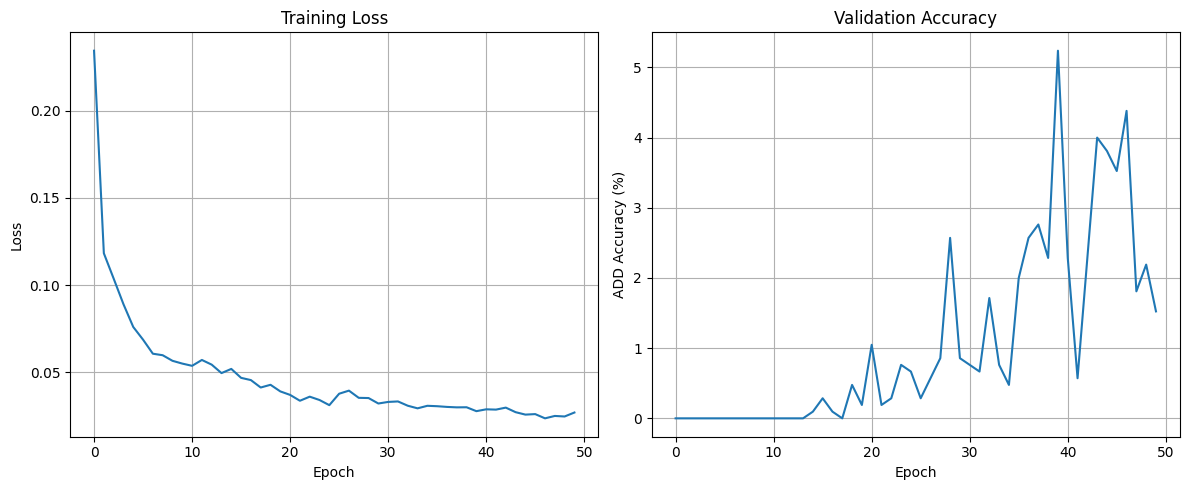


📈 Final Results:
   Best Validation Accuracy: 5.24%
   Final Training Loss: 0.0270

💾 Files saved:
   Checkpoint: /content/drive/My Drive/Project/checkpoint_debugged.pth
   Results: /content/drive/My Drive/Project/results_debugged.json
   Plot: /content/drive/My Drive/Project/training_curves.png


In [1]:
# ==============================================================================
#
# A Transformer-based multi-modal fusion network for 6D pose estimation
# Project Implementation for Google Colab (v5 - Debugged Version)
#
# ==============================================================================

# ==============================================================================
# Part 0: Setup, Imports, and Configuration
# ==============================================================================
print("STEP 0: Installing required libraries...")
!pip install numpy opencv-python-headless pyyaml open3d matplotlib tqdm -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import cv2
import yaml
import os
import open3d as o3d
import time
import json
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm.notebook import tqdm

print("\nSTEP 0: Mounting Google Drive...")
drive.mount('/content/drive')

# --- Main Configuration ---
project_dir = '/content/drive/My Drive/Project'
base_dir = os.path.join(project_dir, 'Linemod_preprocessed')

os.makedirs(project_dir, exist_ok=True)
checkpoint_path = os.path.join(project_dir, 'checkpoint_debugged.pth')
results_path = os.path.join(project_dir, 'results_debugged.json')
plot_path = os.path.join(project_dir, 'training_curves.png')

# --- Training Parameters ---
NUM_EPOCHS = 50
OBJECT_ID_STR = '01'
NUM_POINTS = 500
BATCH_SIZE = 8  # Reduced for stability
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
D_MODEL = 256
N_HEAD = 4
N_LAYERS = 2

print(f"\nConfiguration loaded. Using device: {DEVICE}")
print(f"Project Directory set to: {project_dir}")

# ==============================================================================
# Part 1: DEBUGGED Dataset Class
# ==============================================================================
class DebuggedLinemodDataset(Dataset):
    def __init__(self, root_dir, object_id_str, is_train=True, num_points=500):
        self.root_dir = root_dir
        self.object_id_str = object_id_str
        self.object_id_int = int(object_id_str)
        self.num_points = num_points
        self.is_train = is_train

        print(f"Initializing dataset for object {object_id_str}...")

        data_folder_root = os.path.join(self.root_dir, 'data')
        object_data_path = os.path.join(data_folder_root, self.object_id_str)

        print(f"Looking for data in: {object_data_path}")

        # Check if the directory exists
        if not os.path.exists(object_data_path):
            raise FileNotFoundError(f"Object data path not found: {object_data_path}")

        list_file = os.path.join(object_data_path, 'train.txt' if is_train else 'test.txt')
        print(f"Loading file list from: {list_file}")

        if not os.path.exists(list_file):
            raise FileNotFoundError(f"File list not found: {list_file}")

        with open(list_file) as f:
            self.file_list = [line.strip() for line in f.readlines()]

        print(f"Found {len(self.file_list)} files in list")

        self.rgb_dir = os.path.join(object_data_path, 'rgb')
        self.depth_dir = os.path.join(object_data_path, 'depth')
        self.mask_dir = os.path.join(object_data_path, 'mask')

        # Check if directories exist
        for dir_path, dir_name in [(self.rgb_dir, 'rgb'), (self.depth_dir, 'depth'), (self.mask_dir, 'mask')]:
            if not os.path.exists(dir_path):
                print(f"Warning: {dir_name} directory not found: {dir_path}")
            else:
                print(f"Found {dir_name} directory: {dir_path}")

        # Load ground truth and info data
        gt_file = os.path.join(object_data_path, 'gt.yml')
        info_file = os.path.join(object_data_path, 'info.yml')

        print(f"Loading GT data from: {gt_file}")
        if os.path.exists(gt_file):
            with open(gt_file, 'r') as f:
                self.gt_data = yaml.safe_load(f)
            print(f"Loaded GT data with {len(self.gt_data)} frames")
        else:
            print(f"Error: GT file not found: {gt_file}")
            self.gt_data = {}

        print(f"Loading info data from: {info_file}")
        if os.path.exists(info_file):
            with open(info_file, 'r') as f:
                self.info_data = yaml.safe_load(f)
            print(f"Loaded info data with {len(self.info_data)} frames")
        else:
            print(f"Error: Info file not found: {info_file}")
            self.info_data = {}

        # Load 3D model
        model_file = os.path.join(self.root_dir, 'models', f'obj_{object_id_str}.ply')
        print(f"Loading 3D model from: {model_file}")

        if not os.path.exists(model_file):
            raise FileNotFoundError(f"Model file not found: {model_file}")

        self.model_points = np.asarray(o3d.io.read_point_cloud(model_file).points) / 1000.0
        print(f"Loaded 3D model with {len(self.model_points)} points")

        # Data transforms
        if self.is_train:
            self.rgb_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.rgb_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

        # Precompute valid samples
        print("Precomputing valid samples...")
        self.valid_indices = self._precompute_valid_samples()
        print(f"Found {len(self.valid_indices)} valid samples out of {len(self.file_list)}")

    def _precompute_valid_samples(self):
        """Precompute which samples have all required data"""
        valid_indices = []

        for idx in tqdm(range(len(self.file_list)), desc="Scanning samples"):
            try:
                frame_idx = int(self.file_list[idx])

                # Check if frame exists in data
                if frame_idx not in self.gt_data:
                    continue
                if frame_idx not in self.info_data:
                    continue

                # Check for our object in GT
                found_object = False
                for obj_gt in self.gt_data[frame_idx]:
                    if obj_gt['obj_id'] == self.object_id_int:
                        found_object = True
                        break
                if not found_object:
                    continue

                # Check if files exist
                rgb_file = os.path.join(self.rgb_dir, f'{self.file_list[idx]}.png')
                depth_file = os.path.join(self.depth_dir, f'{self.file_list[idx]}.png')
                mask_file = os.path.join(self.mask_dir, f'{self.file_list[idx]}.png')

                if not all(os.path.exists(f) for f in [rgb_file, depth_file, mask_file]):
                    continue

                # Quick check if files can be loaded
                try:
                    rgb_img = cv2.imread(rgb_file)
                    if rgb_img is None:
                        continue

                    depth_img = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED)
                    if depth_img is None:
                        continue

                    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        continue

                    # Check if mask has valid pixels
                    if np.sum(mask > 0) == 0:
                        continue

                except Exception as e:
                    continue

                valid_indices.append(idx)

            except Exception as e:
                continue

        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid indices
        actual_idx = self.valid_indices[idx]
        frame_idx = int(self.file_list[actual_idx])

        # Load camera parameters
        cam_k = np.array(self.info_data[frame_idx]['cam_K']).reshape(3, 3)
        fx, fy, cx, cy = cam_k[0, 0], cam_k[1, 1], cam_k[0, 2], cam_k[1, 2]
        depth_scale = self.info_data[frame_idx]['depth_scale']

        # Get ground truth
        gt_rotation, gt_translation = None, None
        for obj_gt in self.gt_data[frame_idx]:
            if obj_gt['obj_id'] == self.object_id_int:
                gt_rotation = np.array(obj_gt['cam_R_m2c']).reshape(3, 3)
                gt_translation = np.array(obj_gt['cam_t_m2c']) / 1000.0
                break

        # Load images
        rgb_img = cv2.imread(os.path.join(self.rgb_dir, f'{self.file_list[actual_idx]}.png'))
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

        depth_img = cv2.imread(os.path.join(self.depth_dir, f'{self.file_list[actual_idx]}.png'), cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(os.path.join(self.mask_dir, f'{self.file_list[actual_idx]}.png'), cv2.IMREAD_GRAYSCALE)

        # Process mask
        indices = np.where(mask > 0)
        y_min, y_max = np.min(indices[0]), np.max(indices[0])
        x_min, x_max = np.min(indices[1]), np.max(indices[1])

        # Add padding to bounding box
        padding = 15
        y_min = max(0, y_min - padding)
        y_max = min(rgb_img.shape[0], y_max + padding)
        x_min = max(0, x_min - padding)
        x_max = min(rgb_img.shape[1], x_max + padding)

        # Process RGB
        rgb_cropped = rgb_img[y_min:y_max, x_min:x_max]
        rgb_tensor = self.rgb_transform(cv2.resize(rgb_cropped, (128, 128)))

        # Process point cloud
        points = []
        for v, u in zip(*indices):
            if y_min <= v <= y_max and x_min <= u <= x_max:
                d = depth_img[v, u] * depth_scale / 1000.0
                if d > 0:
                    points.append([(u - cx) * d / fx, (v - cy) * d / fy, d])

        points_np = np.array(points)

        # Sample points
        if len(points_np) > self.num_points:
            sample_indices = np.random.choice(len(points_np), self.num_points, replace=False)
        else:
            sample_indices = np.random.choice(len(points_np), self.num_points, replace=True)

        points_tensor = torch.from_numpy(points_np[sample_indices]).float()

        # Data augmentation
        if self.is_train:
            jitter = torch.randn(points_tensor.shape) * 0.002
            points_tensor += jitter

        return {
            'rgb': rgb_tensor,
            'points': points_tensor,
            'gt_rotation': torch.from_numpy(gt_rotation).float(),
            'gt_translation': torch.from_numpy(gt_translation).float(),
        }

# ==============================================================================
# Part 2: Simple Model Architecture
# ==============================================================================
def compute_rotation_matrix_from_ortho6d(ortho6d):
    x, y_raw = ortho6d[:, 0:3], ortho6d[:, 3:6]
    x = nn.functional.normalize(x, p=2, dim=1)
    z = nn.functional.normalize(torch.cross(x, y_raw, dim=1), p=2, dim=1)
    y = torch.cross(z, x, dim=1)
    return torch.stack((x, y, z), dim=2)

class PointNet(nn.Module):
    def __init__(self, i_dim, o_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(i_dim, 64, 1), nn.ReLU(),
            nn.Conv1d(64, 128, 1), nn.ReLU(),
            nn.Conv1d(128, o_dim, 1)
        )
    def forward(self, x):
        return self.net(x.transpose(1, 2)).transpose(1, 2)

class TransformerFusionNet(nn.Module):
    def __init__(self, num_points, d_model, n_head, n_layers):
        super().__init__()
        self.num_points = num_points
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, d_model)
        self.pointnet = PointNet(3, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.pfe_transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pose_predictor = nn.Sequential(
            nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(),
            nn.Conv1d(512, 256, 1), nn.ReLU(),
            nn.Conv1d(256, 9, 1)
        )
        self.confidence_predictor = nn.Sequential(
            nn.Conv1d(d_model * 2, 512, 1), nn.ReLU(),
            nn.Conv1d(512, 256, 1), nn.ReLU(),
            nn.Conv1d(256, 1, 1), nn.Sigmoid()
        )

    def forward(self, rgb, points):
        img_feat = self.pfe_transformer(self.resnet(rgb).unsqueeze(1).repeat(1, self.num_points, 1))
        pnt_feat = self.pfe_transformer(self.pointnet(points))
        comb_feat = torch.cat([img_feat, pnt_feat], dim=2).transpose(1, 2)
        pose_raw = self.pose_predictor(comb_feat).transpose(1, 2)
        conf = self.confidence_predictor(comb_feat).transpose(1, 2)
        best_pose = torch.gather(pose_raw, 1, torch.argmax(conf, dim=1, keepdim=True).repeat(1, 1, 9)).squeeze(1)
        return compute_rotation_matrix_from_ortho6d(best_pose[:, :6]), best_pose[:, 6:]

# ==============================================================================
# Part 3: Training Utilities
# ==============================================================================
def calculate_add_loss(pred_r, pred_t, gt_r, gt_t, model_points):
    pred_pts = torch.matmul(model_points, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
    gt_pts = torch.matmul(model_points, gt_r.transpose(1, 2)) + gt_t.unsqueeze(1)
    return torch.mean(torch.norm(pred_pts - gt_pts, dim=2))

def train_one_epoch(model, loader, optimizer, model_points_tensor):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
        loss = calculate_add_loss(pred_r, pred_t, batch['gt_rotation'].to(DEVICE), batch['gt_translation'].to(DEVICE), model_points_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, model_points_tensor, diameter):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            batch_size = batch['rgb'].size(0)
            total_samples += batch_size
            pred_r, pred_t = model(batch['rgb'].to(DEVICE), batch['points'].to(DEVICE))
            pred_pts = torch.matmul(model_points_tensor, pred_r.transpose(1, 2)) + pred_t.unsqueeze(1)
            gt_pts = torch.matmul(model_points_tensor, batch['gt_rotation'].to(DEVICE).transpose(1, 2)) + batch['gt_translation'].to(DEVICE).unsqueeze(1)
            errors = torch.mean(torch.norm(pred_pts - gt_pts, dim=2), dim=1)
            correct_mask = errors < (0.1 * diameter)
            total_correct += correct_mask.sum().item()
    return (total_correct / total_samples) * 100 if total_samples > 0 else 0.0

# ==============================================================================
# Part 4: Main Execution Block
# ==============================================================================
if __name__ == '__main__':
    print("\n" + "="*60)
    print("DEBUGGED 6D POSE ESTIMATION TRAINING")
    print("="*60)

    print("\nSTEP 1: Initializing DEBUGGED datasets...")
    try:
        train_dataset = DebuggedLinemodDataset(base_dir, OBJECT_ID_STR, is_train=True, num_points=NUM_POINTS)
        test_dataset = DebuggedLinemodDataset(base_dir, OBJECT_ID_STR, is_train=False, num_points=NUM_POINTS)

        print(f"✓ Training dataset: {len(train_dataset)} samples")
        print(f"✓ Test dataset: {len(test_dataset)} samples")

        if len(train_dataset) == 0:
            raise RuntimeError("No training samples found!")
        if len(test_dataset) == 0:
            raise RuntimeError("No test samples found!")

    except Exception as e:
        print(f"❌ Error initializing datasets: {e}")
        print("Please check your data paths and file structure.")
        raise

    print("\nSTEP 2: Creating data loaders...")
    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

    print("✓ Data loaders created successfully")

    print("\nSTEP 3: Loading model info...")
    try:
        models_info_file = os.path.join(base_dir, 'models', 'models_info.yml')
        with open(models_info_file, 'r') as f:
            models_info = yaml.safe_load(f)
        object_diameter = models_info[int(OBJECT_ID_STR)]['diameter'] / 1000.0
        print(f"✓ Object diameter: {object_diameter:.3f}m")
    except Exception as e:
        print(f"❌ Error loading model info: {e}")
        object_diameter = 0.1  # Default fallback

    print("\nSTEP 4: Initializing model and optimizer...")
    model = TransformerFusionNet(NUM_POINTS, D_MODEL, N_HEAD, N_LAYERS).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    model_points_tensor = torch.from_numpy(train_dataset.model_points).float().to(DEVICE)

    print("✓ Model and optimizer initialized")

    # Training state
    start_epoch, best_accuracy = 0, 0.0
    results = {'train_loss': [], 'val_accuracy': []}

    # Load checkpoint if exists
    if os.path.exists(checkpoint_path):
        print("\nSTEP 5: Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_accuracy = checkpoint.get('best_accuracy', 0.0)
        if os.path.exists(results_path):
            with open(results_path, 'r') as f:
                results = json.load(f)
        print(f"✓ Resuming from epoch {start_epoch}. Best accuracy: {best_accuracy:.2f}%")
    else:
        print("\nSTEP 5: No checkpoint found. Starting fresh training.")

    print(f"\nSTEP 6: Starting training for {NUM_EPOCHS} epochs...")
    print(f"Training on object: {OBJECT_ID_STR}")
    print(f"Batch size: {BATCH_SIZE}, Learning rate: {LEARNING_RATE}")

    for epoch in range(start_epoch, NUM_EPOCHS):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS}")
        print(f"{'='*50}")

        start_time = time.time()

        # Training phase
        train_loss = train_one_epoch(model, train_loader, optimizer, model_points_tensor)

        # Evaluation phase
        accuracy = evaluate(model, test_loader, model_points_tensor, object_diameter)

        # Update learning rate
        scheduler.step()

        # Update results
        results['train_loss'].append(train_loss)
        results['val_accuracy'].append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"🎯 New best accuracy: {best_accuracy:.2f}%")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
        }, checkpoint_path)

        with open(results_path, 'w') as f:
            json.dump(results, f)

        epoch_time = time.time() - start_time
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Time: {epoch_time:.2f}s")
        print(f"   Train Loss: {train_loss:.4f}")
        print(f"   Val Accuracy: {accuracy:.2f}%")
        print(f"   Best Accuracy: {best_accuracy:.2f}%")

    print(f"\n{'='*60}")
    print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print(f"{'='*60}")

    print("\nSTEP 7: Generating results plots...")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(results['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('ADD Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📈 Final Results:")
    print(f"   Best Validation Accuracy: {best_accuracy:.2f}%")
    print(f"   Final Training Loss: {results['train_loss'][-1]:.4f}")

    print(f"\n💾 Files saved:")
    print(f"   Checkpoint: {checkpoint_path}")
    print(f"   Results: {results_path}")
    print(f"   Plot: {plot_path}")